# Manual code for interpolation

[DEBUG] Container size: 1335
[DEBUG] Actual size: 211
[DEBUG] Found tolerance: 0.001
[DEBUG] Number of original vertices: 10270
[DEBUG] Number of overlapped vertices:  13
[DEBUG] Number of interpolated vertices (origin inclusive):  26721
[DEBUG] Time:  1.2189202308654785


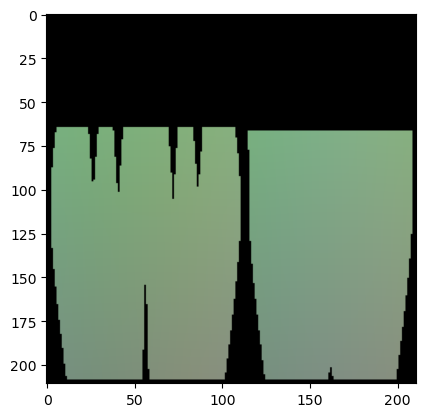

1.5031630992889404


In [6]:
import time
from src.preprocessing.unwarping import create_geometry_uv
from configs import GLOBAL_CONFIG
import yaml

with open(GLOBAL_CONFIG.config_dir / "preprocessing.yaml", "r") as file:
    config = yaml.safe_load(file)

path_to_mesh = "/home/phphuc/Desktop/GarmentRecon/GarmentCode/data/GarmentCodeData_v2/GarmentCodeData_v2/garments_5000_0/random_body/data/rand_XYPRVU9C8D/rand_XYPRVU9C8D_sim.ply"
path_to_texture = "/home/phphuc/Desktop/GarmentRecon/GarmentCode/data/GarmentCodeData_v2/GarmentCodeData_v2/garments_5000_0/random_body/data/rand_XYPRVU9C8D/rand_XYPRVU9C8D_texture.png"
start = time.time()
img = create_geometry_uv(
    obj_file_path=path_to_mesh,
    texture_file_path=path_to_texture,
    geometry_uv_path="./running",
    plot=True,
    **config,
)
print(time.time() - start)

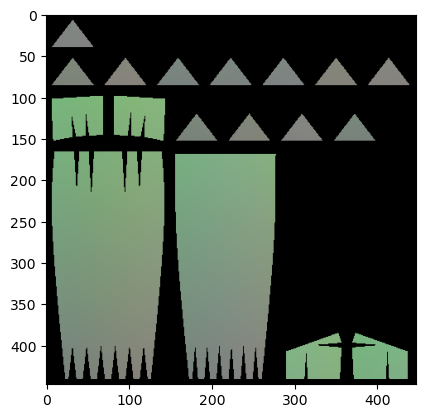

Size:  (447, 447, 3)
Reconstructed 3D mesh saved to ./reconstructed_mesh.obj


In [2]:
import numpy as np
import trimesh


def reconstruct_mesh_from_geometry_map(geometry_map_npy_path, output_obj_path):
    if isinstance(geometry_map_npy_path, str):
        geometry_map = np.load(geometry_map_npy_path)[
            'arr_0']  # Shape: (height, width, 3)
    else:
        geometry_map = geometry_map_npy_path

    import matplotlib.pyplot as plt
    plt.imshow(geometry_map)
    plt.show()

    height, width, _ = geometry_map.shape

    vertices = []
    uvs = []

    for y in range(height):
        for x in range(width):
            r, g, b = geometry_map[y, x]
            if np.isclose(r, 0) and np.isclose(g, 0) and np.isclose(b, 0):
                continue

            vertex = np.array([r, g, b], dtype=np.float32)
            vertices.append(vertex)

            uv = [x / width, (height - y) / height]  # Top-left flipped
            uvs.append(uv)

    vertices = np.array(vertices, dtype=np.float32)
    uvs = np.array(uvs, dtype=np.float32)

    mesh = trimesh.Trimesh(vertices=vertices, process=False)
    mesh.visual = trimesh.visual.TextureVisuals(uv=uvs)
    mesh.export(output_obj_path)
    print(f"Size: ", geometry_map.shape)
    print(f"Reconstructed 3D mesh saved to {output_obj_path}")


geometry_map_npy_path = "/home/phphuc/Desktop/GarmentRecon/GarmentCode/data/GarmentCodeData_v2/GarmentCodeData_v2/garments_5000_0/random_body/data/rand_XL6E9AVJEI/rand_XL6E9AVJEI_gim.npz"
output_obj_path = "./reconstructed_mesh.obj"


reconstruct_mesh_from_geometry_map(
    geometry_map_npy_path, output_obj_path)

In [8]:
print("/home/phphuc/Desktop/GarmentRecon/GarmentCode/data/GarmentCodeData_v2/GarmentCodeData_v2/garments_5000_0/random_body/data/rand_9MUWO9L0J2/")

/home/phphuc/Desktop/GarmentRecon/GarmentCode/data/GarmentCodeData_v2/GarmentCodeData_v2/garments_5000_0/random_body/data/rand_9MUWO9L0J2/


In [9]:
np.load(geometry_map_npy_path)['arr_0']

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

In [10]:
from pathlib import Path
import trimesh
from src.utils.mics import get_all_gcd_files
import numpy as np
import pandas as pd

samples = get_all_gcd_files()
print(len(samples))

file_sizes = []
sample_sizes = []
pointcloud_sizes = []
not_normal_samples = pd.DataFrame(
    columns=["sample_id", "path", "sample_size", "pointcloud_size", "file_size"])
for sample in samples:
    path = Path(sample)
    sample_id = path.name

    gim_path = path / f"{sample_id}_geometry.npy"
    ply_path = path / f"{sample_id}_sim.ply"
    if Path(gim_path).exists():
        data = np.load(gim_path)
        mesh = trimesh.load_mesh(ply_path)
        sample_sizes.append(data.shape[0])
        pointcloud_sizes.append(mesh.vertices.shape[0])
        file_sizes.append(data.nbytes / (1024 * 1024))  # Convert bytes to MB

    if (sample_sizes[-1] ** 2) / pointcloud_sizes[-1] > 99:
        print(sample_sizes[-1], pointcloud_sizes[-1], file_sizes[-1])
        not_normal_samples.loc[len(not_normal_samples)] = [sample_id, path,
                                                           sample_sizes[-1], pointcloud_sizes[-1], file_sizes[-1]]

not_normal_samples.to_csv("not_normal_samples.csv", index=False)

6755


IndexError: list index out of range

In [ ]:
import pandas as pd

df = pd.DataFrame({
    "sample_size": sample_sizes,
    "pc_size": pointcloud_sizes,
    "file_size": file_sizes
})

print(df.describe())

In [ ]:
print('/home/phphuc/Desktop/GarmentRecon/GarmentCode/data/GarmentCodeData_v2/GarmentCodeData_v2/garments_5000_0/random_body/data/rand_7EH5EMJZPM')

# Delaunay code

In [ ]:
from scipy.spatial import Delaunay
import numpy as np
from time import time
import matplotlib.pyplot as plt

t = time()

a, b, c = [250, 100], [100, 400], [400, 400]

tri = Delaunay(np.array([a, b, c]))

# bounding box of the triangle
xleft, xright = min(a[0], b[0], c[0]), max(a[0], b[0], c[0])
ytop, ybottom = min(a[1], b[1], c[1]), max(a[1], b[1], c[1])

xv, yv = np.meshgrid(range(xleft, xright), range(ytop, ybottom))
xv, yv = xv.flatten(), yv.flatten()
pp = np.vstack((xv, yv)).T
ss = tri.find_simplex(pp)
ndim = tri.transform.shape[2]

out = np.zeros((450, 450, 3), dtype=np.uint8)
for i in np.unique(ss):  # for all simplices (triangles)
    p = pp[ss == i]  # all points in the simplex
    # compute the barycentric coordinates of the points
    b = tri.transform[i, :ndim].dot(np.transpose(
        p) - tri.transform[i, ndim].reshape(-1, 1))
    color = np.c_[np.transpose(b), 1 - bb.sum(axis=0)]
    indices = np.where(np.all(color >= 0, axis=1))
    out[p[indices, 0], p[indices, 1]
        ] = color[indices] @ np.array([[0, 0, 255], [0, 255, 0], [255, 0, 0]])

In [ ]:
from cupyx.scipy.spatial import Delaunay

In [ ]:
import cupy as cp
from cupyx.scipy.spatial import Delaunay
from time import time
import matplotlib.pyplot as plt

t = time()

a, b, c = [250, 100], [100, 400], [400, 400]

tri = Delaunay(cp.array([a, b, c]))

# bounding box of the triangle
xleft, xright = min(a[0], b[0], c[0]), max(a[0], b[0], c[0])
ytopy, ybottom = min(a[1], b[1], c[1]), max(a[1], b[1], c[1])

xv, yv = cp.meshgrid(cp.arange(xleft, xright), cp.arange(ytopy, ybottom))
xv, yv = xv.flatten(), yv.flatten()
pp = cp.vstack((xv, yv)).T
ss = tri.find_simplex(pp)
ndim = tri.transform.shape[2]

out = cp.zeros((450, 450, 3), dtype=cp.uint8)
for i in cp.unique(ss):  # for all simplices (triangles)
    p = pp[ss == i]  # all points in the simplex
    # compute the barycentric coordinates of the points
    b = tri.transform[i, :ndim].dot(cp.transpose(
        p) - tri.transform[i, ndim].reshape(-1, 1))
    color = cp.c_[cp.transpose(b), 1 - b.sum(axis=0)]
    indices = cp.where(cp.all(color >= 0, axis=1))
    out[p[indices, 0], p[indices, 1]
        ] = color[indices] @ cp.array([[0, 0, 255], [0, 255, 0], [255, 0, 0]])

# Transfer the result back to CPU for visualization
out_cpu = cp.asnumpy(out)
plt.imshow(out_cpu)
plt.show()

In [ ]:
from scipy.spatial import Delaunay
import numpy as np
from time import time
import matplotlib.pyplot as plt


def print_time(t):
    print(f'time: {time() - t} sec')
    t = time()
    return t


t = time()
tt = time()

a, b, c = [0, 0], [0, 1800], [1700, 1800]

tri = Delaunay(np.array([a, b, c]))

print('Delaunay')
t = print_time(t)

# bounding box of the triangle
xleft, xright = min(a[0], b[0], c[0]), max(a[0], b[0], c[0])
ytop, ybottom = min(a[1], b[1], c[1]), max(a[1], b[1], c[1])

xv, yv = np.meshgrid(range(xleft, xright), range(ytop, ybottom))
xv, yv = xv.flatten(), yv.flatten()

print('Meshgrid')
t = print_time(t)

pp = np.vstack((xv, yv)).T
ss = tri.find_simplex(pp)
ndim = tri.transform.shape[2]
print(len(np.unique(ss)))
# 2

print('Simplex')
t = print_time(t)


out = np.zeros((2000, 2000, 3), dtype=np.uint8)
for i in np.unique(ss):  # for all simplices (triangles)
    p = pp[ss == i]  # all points in the simplex
    # compute the barycentric coordinates of the points
    b = tri.transform[i, :ndim].dot(np.transpose(
        p) - tri.transform[i, ndim].reshape(-1, 1))
    αβγ = np.c_[np.transpose(b), 1 - b.sum(axis=0)]
    indices = np.where(np.all(αβγ >= 0, axis=1))
    # out[p[indices, 0], p[indices, 1]
    #     ] = αβγ[indices] @ np.array([[0, 0, 255], [0, 255, 0], [255, 0, 0]])

print('Fill color')
t = print_time(t)
print(f'time: {time() - tt} sec')
# time: 0.03899240493774414 sec

plt.imshow(out)

# GPU testing

In [ ]:
import torch
import numpy as np

from src.preprocessing.object_loading import read_mesh
from src.preprocessing.unwarping import normalize_squared_UVs, unwarp_UV


_MAX_SIZE = (1 << 16)


def interpolate_uv(
    uv_coords: np.ndarray,
    norm_vertex_coords: np.ndarray,
    vertex_faces: np.ndarray,
    texture_faces: np.ndarray,
    device="cuda",
):
    # Convert to int for pixel coordinates
    # origin uv_size is in cm

    actual_size, left, right = -1, 0, _MAX_SIZE

    while left < right:
        mid = left + ((right - left) >> 1)
        scaled_coords = (uv_coords * mid).astype(int)
        if np.unique(scaled_coords, axis=0).shape[0] == uv_coords.shape[0]:
            actual_size = mid
            right = mid
        else:
            left = mid + 1

    assert actual_size != -1, "Cannot find a valid size for UV"
    width, height = actual_size, actual_size

    print(f"[DEBUG] Actual size: {actual_size}")

    img_array = np.zeros((height, width, 3), dtype=float)

    # scale to original uv coordinates and flip the V axis
    scaled_coords = (uv_coords * [width, height]).astype(int)
    scaled_coords[:, 1] = height - scaled_coords[:, 1]

    # Convert to tensor and to gpu
    texture_faces = torch.tensor(texture_faces, device=device)
    vertex_faces = torch.tensor(vertex_faces, device=device)
    scaled_coords = torch.tensor(scaled_coords, dtype=torch.float, device=device)
    norm_vertex_coords = torch.tensor(norm_vertex_coords, device=device)
    img_array = torch.tensor(img_array, device=device)

    def _in_triangle_gpu(p, a, b, c):
        """Check if point(s) p is inside triangle abc using PyTorch GPU acceleration, preserving original logic."""

        def _sign(pt1, pt2, pt3):
            pt2 = pt2.unsqueeze(0)
            pt3 = pt3.unsqueeze(0)
            return (
                (pt1[:, 0] - pt3[:, 0]) * (pt2[:, 1] - pt3[:, 1])
                - (pt2[:, 0] - pt3[:, 0]) * (pt1[:, 1] - pt3[:, 1])
            )

        assert len(p.shape) == 2, "Point(s) p must be a 2D tensor"

        # Compute the signs for the point relative to each triangle edge
        d1 = _sign(p, a, b)
        d2 = _sign(p, b, c)
        d3 = _sign(p, c, a)

        # Check if the signs are consistent (all positive or all negative)
        has_neg = (d1 < 0) | (d2 < 0) | (d3 < 0)
        has_pos = (d1 > 0) | (d2 > 0) | (d3 > 0)

        return ~(has_neg & has_pos)

    from time import time

    def timeit(t):
        print(f"time: {time() - t} sec")
        t = time()
        return t

    t = time()
    all_t = time()

    def _interpolate(face_id):
        t = time()
        triangles = scaled_coords[texture_faces[face_id]]
        # print(a, b, c)
        print(triangles.shape)
        min_x, min_y = torch.min(triangles, dim=0).values
        max_x, max_y = torch.max(triangles, dim=0).values
        a, b, c = triangles

        print("Init")
        t = timeit(t)

        vertex_coords = norm_vertex_coords[vertex_faces[face_id]]
        a_color, b_color, c_color = vertex_coords

        v0 = b - a
        v1 = c - a
        d00 = torch.dot(v0, v0)
        d01 = torch.dot(v0, v1)
        d11 = torch.dot(v1, v1)
        denom = d00 * d11 - d01 * d01

        print("Init")
        t = timeit(t)

        x_coords = torch.arange(min_x, max_x, device='cuda')
        y_coords = torch.arange(min_y, max_y, device='cuda')

        print("list out")
        t = timeit(t)

        x_grid, y_grid = torch.meshgrid(x_coords, y_coords, indexing='ij')
        points = torch.stack([x_grid.flatten(), y_grid.flatten()], dim=1)

        print("Meshgrid")
        t = timeit(t)

        inside_mask = _in_triangle_gpu(points, a, b, c)
        inside_points = points[inside_mask].long()

        if inside_points.shape[0] == 0:
            return

        print("In triangle")
        t = timeit(t)

        v2 = inside_points - a.unsqueeze(0)
        d20 = v2 @ v0.unsqueeze(1)
        d21 = v2 @ v1.unsqueeze(1)

        alp = (d11 * d20 - d01 * d21) / denom
        bet = (d00 * d21 - d01 * d20) / denom
        gam = 1 - alp - bet

        colors = a_color * alp + b_color * \
            bet + c_color * gam

        print("Interpolate")
        t = timeit(t)

        img_array[inside_points[:, 1], inside_points[:, 0]] = colors

        print("Assign")
        t = timeit(t)

    from tqdm import tqdm
    for i in tqdm(range(len(vertex_faces))):
        _interpolate(i)
        t = timeit(t)
        break

    print(f'time: {time() - all_t} sec')

    return img_array.cpu().numpy()


def create_geometry_uv(
    obj_file_path,
    texture_file_path,
    geometry_uv_path,
    max_dim: int = 300,
    island_padding_percent: int = 2,
    plot: bool = False,
):
    (
        uv_coords,
        vertex_coords,
        texture_faces,
        vertex_faces,
    ) = read_mesh(obj_file_path, texture_file_path)

    assert 0 < island_padding_percent <= 100, "Invalid padding percentage"
    _max_ori_uv_size = max(uv_coords.max(axis=0) - uv_coords.min(axis=0))
    padding = _max_ori_uv_size * (island_padding_percent / 100)

    all_uvs, _ = unwarp_UV(
        uv_coords,
        texture_faces,
        padding=padding,
    )

    uv_list, _ = normalize_squared_UVs(
        all_uvs,
        padding=padding,
    )

    # Create geometry uv file
    norm_vertex_coords = (vertex_coords + max_dim) / (2 * max_dim)
    img_array = interpolate_uv(
        uv_list,
        norm_vertex_coords,
        vertex_faces,
        texture_faces,
    )

    if plot:
        import matplotlib.pyplot as plt

        plt.imshow(img_array)
        plt.show()

    np.save(geometry_uv_path, img_array)
    return img_array

In [ ]:
path_to_mesh = "/home/phphuc/Desktop/GarmentRecon/GarmentCode/test_data/GarmentCodeData_v2/garments_5000_0/default_body/data/rand_0AAY3NQH8J/rand_0AAY3NQH8J_sim.ply"
path_to_texture = "/home/phphuc/Desktop/GarmentRecon/GarmentCode/test_data/GarmentCodeData_v2/garments_5000_0/default_body/data/rand_0AAY3NQH8J/rand_0AAY3NQH8J_texture.png"
img = create_geometry_uv(
    obj_file_path=path_to_mesh,
    texture_file_path=path_to_texture,
    geometry_uv_path="./running.npy",
    plot=True,
    island_padding_percent=2,
)

# Downsampling

In [ ]:
import numpy as np
import scipy
import skimage
import einops


def downsample_omg(omg: np.ndarray, target_size: int = 64, anti_aliasing=False, visualize=False):
    """downsample omg with edge snapping
    Args:
        omg: np.ndarray, (H, W, 4), omage tensor
        factor: int, downsample factor
        anti_aliasing: bool, whether to use anti_aliasing
        visualize: bool, whether to visualize the result
    Returns:
        dict, containing 'omg_down_star', 'omg_down', 'sov', 'edge_occ_down'
        'omg_down_star': np.ndarray, downsampled omg with edge snapping
        'omg_down': np.ndarray, downsampled omg without edge snapping
        'sov': np.ndarray, occupancy map with snapped boundaries highlighted
        'edge_occ_down': np.ndarray, edge occupancy map
    """
    assert omg.shape[0] == omg.shape[1], "Input omg must be square"

    # Padded omg to the nearest multiple of target_size
    padded_size = (omg.shape[0] + target_size - 1) // target_size * target_size
    pad_top = pad_left = (padded_size - omg.shape[0]) // 2
    pad_bottom = pad_right = padded_size - omg.shape[0] - pad_top

    padded_omg = np.pad(
        omg,
        (
            (pad_top, pad_bottom),
            (pad_left, pad_right),
            (0, 0)  # no padding for channel
        ),
        mode='constant',
        constant_values=-1
    )
    omg = padded_omg
    factor = omg.shape[0] // target_size

    # TODO: resolove for < 64 x 64 omage

    # Occupancy map (all channels == 0)
    occ = np.any(omg != 0, axis=-1)

    # Extract edge in occupancy map
    # Edge = Occupancy map - Erosion of occupancy map
    eroded_mask = scipy.ndimage.binary_erosion(
        occ, structure=np.ones((3, 3))
    )  # square structure is needed to get the corners
    edge_occ = ~eroded_mask & occ
    edge_omg = omg.copy()
    edge_omg[edge_occ == 0] = -1.

    # Seperate edge_occ and edge_omg into patches
    edge_occ_patches = einops.rearrange(
        edge_occ, "(h1 h2) (w1 w2) -> h1 w1 h2 w2", h2=factor, w2=factor
    )
    edge_occ_down = edge_occ_patches.max(axis=-1).max(axis=-1)
    eod_0_count = (edge_occ_patches == 0).sum(axis=-1).sum(axis=-1)
    eod_1_count = (edge_occ_patches == 1).sum(axis=-1).sum(axis=-1)
    edge_omg_patches = einops.rearrange(
        edge_omg, "(h1 h2) (w1 w2) c-> h1 w1 h2 w2 c", h2=factor, w2=factor
    )
    edge_omg_down = (
        edge_omg_patches.sum(axis=-2).sum(axis=-2) + eod_0_count[..., None]
    )
    edge_omg_down = np.divide(
        edge_omg_down,
        eod_1_count[..., None],
        out=np.zeros_like(edge_omg_down),
        where=eod_1_count[..., None] != 0,
    )

    omg_down = skimage.transform.resize(
        omg,
        (omg.shape[0] // factor,) * 2,
        order=0,
        preserve_range=False,
        anti_aliasing=anti_aliasing,
    )

    omg_down_star = edge_omg_down * (edge_occ_down[..., None]) + omg_down * (
        1 - edge_occ_down[..., None]
    )

    sov = np.any(omg_down != 0, axis=-1)  # for visualizaton
    sov = sov * 0.5 + edge_occ_down.astype(float)
    sov[sov >= 1.0] = 1.0
    if visualize:
        import matplotlib.pyplot as plt

        plt.imshow(sov, cmap="gray")
        plt.show()
        plt.imshow(edge_occ_down, cmap="gray")
        plt.show()
        plt.imshow(omg_down)
        plt.show()
        plt.imshow(omg_down_star)
        plt.show()

    return dict(
        omg_down_star=np.clip(omg_down_star, 0, 1),
        omg_down=np.clip(omg_down, 0, 1),
        sov=sov,
        edge_occ_down=edge_occ_down,
        edge_occ=edge_occ,
    )

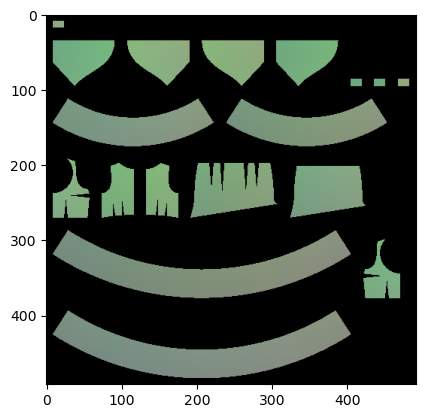

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

omg = np.load(
    "/home/phphuc/Desktop/GarmentRecon/GarmentCode/test_data/GarmentCodeData_v2/GarmentCodeData_v2/garments_5000_0/random_body/data/rand_0A6EZQVATK/rand_0A6EZQVATK_gim.npz")['arr_0']

# omg = np.load(
#    "/home/phphuc/Desktop/GarmentRecon/GarmentCode/data/GarmentCodeData_v2/GarmentCodeData_v2/garments_5000_0/random_body/data/rand_XL6E9AVJEI/rand_XL6E9AVJEI_gim.npz")['arr_0']


plt.imshow(omg)

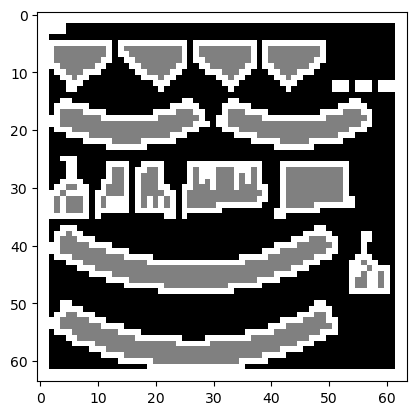

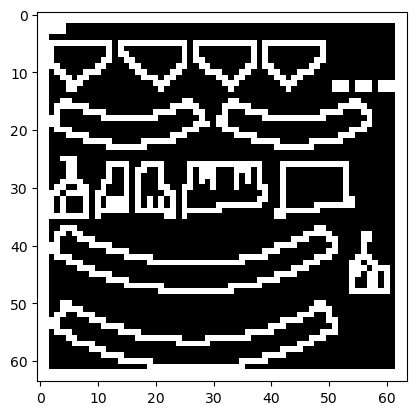

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7233664239043351].


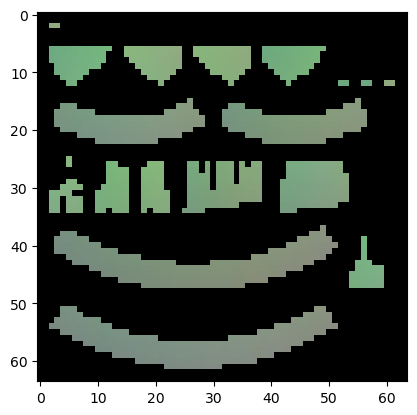

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7238719954119439].


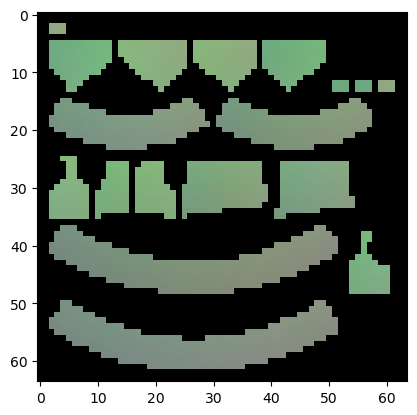

In [ ]:
result = downsample_omg(omg, target_size=64, visualize=True)

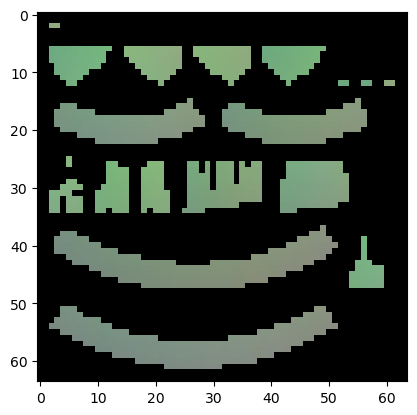

Size:  (64, 64, 3)
Reconstructed 3D mesh saved to ./reconstructed_mesh.obj


In [ ]:
reconstruct_mesh_from_geometry_map(
    result['omg_down'], output_obj_path
)

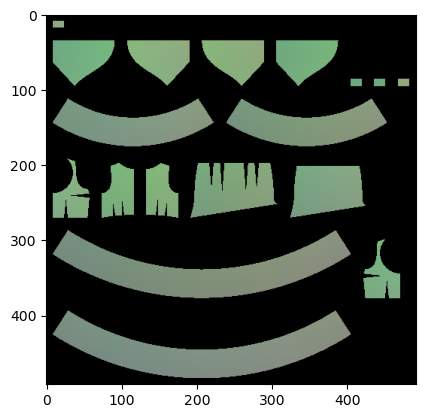

Size:  (492, 492, 3)
Reconstructed 3D mesh saved to ./reconstructed_ori.obj


In [ ]:
reconstruct_mesh_from_geometry_map(
    omg, "./reconstructed_ori.obj"
)

# Seed testing

In [ ]:
import numpy as np
import contextlib


@contextlib.contextmanager
def temp_seed(seed):
    state = np.random.get_state()  # Save current state
    np.random.seed(seed)  # Set new temporary seed
    try:
        yield
    finally:
        np.random.set_state(state)  # Restore previous state


np.random.seed(42)
# Check effect before and after using temp_seed
print("Before temp_seed:", np.random.randint(0, 1000))

with temp_seed(42):
    print("Inside temp_seed:", np.random.randint(0, 1000))

print("After temp_seed:", np.random.randint(0, 1000))  # Should continue from before

# Chamfer distance

In [ ]:
import torch
from chamfer_distance import ChamferDistance as chamfer_dist
from src.utils.mics import get_all_gcd_files
from src.datasets.utils import scale_omg
from pathlib import Path


def compute_chamfer_distance(p1, p2):
    chd = chamfer_dist().to("cuda")
    dist1, dist2, idx1, idx2 = chd(p1, p2)
    loss = (torch.mean(dist1)) + (torch.mean(dist2))
    return loss


all_files = get_all_gcd_files()
all_losses = []
for f in all_files:
    file_path = Path(f)
    gim_path = file_path / f"{file_path.name}_gim.npz"

    if not gim_path.exists():
        continue
    
    omg = np.load(gim_path)['arr_0']
    ori = torch.tensor(omg, dtype=torch.float32).to("cuda").view(-1, 3).unsqueeze(0)
    omg = scale_omg(omg, 64)['omg_down']
    omg = torch.tensor(omg, dtype=torch.float32).to("cuda") # (64, 64, 3)
    down = omg.view(-1, 3).unsqueeze(0)
    
    loss = compute_chamfer_distance(ori, down)
    all_losses.append(loss.item())
   

In [ ]:
# only_down = all_losses
sum(all_losses)

In [ ]:
sum(all_losses)